# Privacy Analysis

Because we don't have a ground-truth for NER, hard to know what is the right amount of privacy or not.

In [53]:
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine
from presidio_anonymizer.entities.engine import RecognizerResult, OperatorConfig
from collections import Counter
from collections import defaultdict 
from nltk.tokenize import sent_tokenize, word_tokenize
import re, json
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.reload_library()
plt.style.use('science')

# Set color palette to ORCA palette
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#68829D', '#329B8A', '#D24437', '#F5B100', '#62ABB9', '#A3B100'])


In [2]:
# pip install presidio-analyzer
# pip install presidio-anonymizer
# python -m spacy download en_core_web_sm

In [3]:
# Initialize the engine with logger.
anonymizer = AnonymizerEngine()
analyzer = AnalyzerEngine()

In [4]:
# By Sasha

# Need to add more to vaxlist

def find_vaccines(text):
    vaccines = Counter()
    vaxlist=['Pfizer', 'Moderna', 'Janssen', 'Astra', 'Zeneca', 'Zenica', 'AstraZeneca', 'Astrazeneca', 'Oxford','Johnson'
            'COVAX', 'Omicron', 'Covidex', 'Covilyce', 'Covid', 'Moderna']
    for word in vaxlist:
        text=re.sub(word, '*'+word+'*', text, flags=re.I)
    return(text)



def get_anonymized(doc):
    """
        If we want to return the text with the PII replaced
    """
    anonresult = anonymizer.anonymize(doc, analyzer.analyze(text=doc,
                               entities=entlist,
                               language='en'))
    final=json.loads(anonresult.to_json())
    return final['text']


def get_anonymized_entities(doc):
    """
        returns the PII entities being replaced
    """
    if len(doc) == 0:
        return []
    
    doc = find_vaccines(doc)
    
    anonresult = anonymizer.anonymize(doc, analyzer.analyze(text=doc,
                               entities=entlist,
                               language='en'))
    final=json.loads(anonresult.to_json())
    return [i['entity_type'] for i in final['items']]

def get_detected_entites(doc):
    """ Just run the analyzer """
    if len(doc) == 0:
        return []
    doc = find_vaccines(doc)
    analyzer_result = analyzer.analyze(text=doc, entities=entlist, language='en')
    
    return [doc[i.start:i.end] for i in analyzer.analyze(text=doc, entities=entlist, language='en')]

def get_detected_entity_types(doc):
    """ Just run the analyzer """
    if 
    if len(doc) == 0:
        return []
    doc = find_vaccines(doc)
    analyzer_result = analyzer.analyze(text=doc, entities=entlist, language='en')
    
    return [i.entity_type for i in analyzer.analyze(text=doc, entities=entlist, language='en')]


In [5]:
entlist=["PERSON", "PHONE_NUMBER", "NRP", "LOCATION"]

### On the transcriptons

In [29]:
english_clips = pd.read_csv('data/english_clips_transcriptions.csv')

# Remove the one row where deepspeech is null
english_clips = english_clips[english_clips["transcription_deepspeech"].notnull()]

# Set type as string
for asr in ["riva", "deepspeech", "aws", "human1", "human2"]:
    col_name = f"transcription_{asr}"
    english_clips[col_name] = english_clips[col_name].astype("string")

In [33]:
english_clips["pii_human1"] = english_clips["transcription_human1"].apply(get_detected_entites)
english_clips["pii_human2"] = english_clips["transcription_human1"].apply(get_detected_entites)
english_clips["pii_riva"] = english_clips["transcription_riva"].apply(get_detected_entites)
english_clips["pii_deepspeech"] = english_clips["transcription_deepspeech"].apply(get_detected_entites)
english_clips["pii_aws"] = english_clips["transcription_aws"].apply(get_detected_entites)

In [34]:
english_clips["pii_types_human1"] = english_clips["transcription_human1"].apply(get_detected_entity_types)
english_clips["pii_types_human2"] = english_clips["transcription_human2"].apply(get_detected_entity_types)
english_clips["pii_types_riva"] = english_clips["transcription_riva"].apply(get_detected_entity_types)
english_clips["pii_types_deepspeech"] = english_clips["transcription_deepspeech"].apply(get_detected_entity_types)
english_clips["pii_types_aws"] = english_clips["transcription_aws"].apply(get_detected_entity_types)



In [35]:
# A df of the piis found and removed in the transcriptions
pii_df = english_clips[["pii_riva", "pii_deepspeech", "pii_aws", "pii_human1", "pii_human2",
                       "pii_types_riva", "pii_types_deepspeech", "pii_types_aws", "pii_types_human1", "pii_types_human2"
                       ]]

In [36]:
for c in pii_df.columns:
    pii_df[f"{c}_len"] = pii_df[c].apply(len)

<ipython-input-36-c7c258aeb444>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pii_df[f"{c}_len"] = pii_df[c].apply(len)


In [37]:
pii_df.to_csv('data/pii_df.csv', index=False)

In [53]:
# pii_df = pd.read_csv('pii_df.csv')

In [38]:
# RIVA types counter
riva_pii = Counter([a for sublist in pii_df["pii_types_riva"] for a in sublist]).most_common()

# Deepspeech counter
ds_pii = Counter([a for sublist in pii_df["pii_types_deepspeech"] for a in sublist]).most_common()

# AWS counter
aws_pii = Counter([a for sublist in pii_df["pii_types_aws"] for a in sublist]).most_common()

# Human transcription 1 counter
human1_pii = Counter([a for sublist in pii_df["pii_types_human1"] for a in sublist]).most_common()

# Human transcription 1 counter
human2_pii = Counter([a for sublist in pii_df["pii_types_human2"] for a in sublist]).most_common()

In [43]:
pii_df_2 = pd.DataFrame([riva_pii, ds_pii, aws_pii, human1_pii, human2_pii])
pii_df_2.columns=['Location', 'Person', 'NRP', 'Phone Number']
pii_df_2 = pii_df_2.fillna(0)

In [45]:
def extract_count(row):
    if row != 0:
        w,c = row
        return c
    else: return 0
    
pii_df_2 = pii_df_2.applymap(lambda x: extract_count(x))
pii_df_2.index = ["Riva", "DS", "Amazon", "Human1", "Human2"]


In [46]:
pii_df_2

,Location,Person,NRP,Phone Number
Riva,69,54,18,0
DS,37,33,13,0
Amazon,75,49,25,3
Human1,64,27,23,2
Human2,62,39,25,3


In [47]:
def get_perc_diff(x):
    return (x - pii_df_2.loc['Human1'])/pii_df_2.loc['Human1']

pii_percent_diff = pii_df_2.apply(get_perc_diff, axis=1)
pii_percent_diff = pii_percent_diff.loc[["DS", "Riva", "Amazon", "Human2"]].reset_index()
pii_percent_diff = pii_percent_diff.melt(id_vars='index')
pii_percent_diff.columns=['model', 'variable', 'p_change']

In [48]:
pii_percent_diff["p_change"] * 100

0     -42.187500
1       7.812500
2      17.187500
3      -3.125000
4      22.222222
5     100.000000
6      81.481481
7      44.444444
8     -43.478261
9     -21.739130
10      8.695652
11      8.695652
12   -100.000000
13   -100.000000
14     50.000000
15     50.000000
Name: p_change, dtype: float64

<ipython-input-77-d5cc0a03cbbb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["p_change"] = data["p_change"] * 100


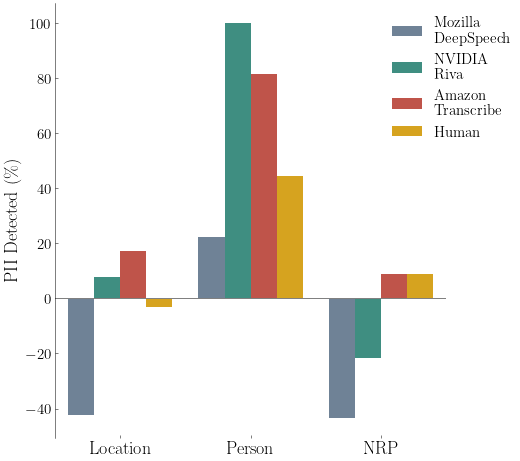

In [77]:
data = pii_percent_diff[pii_percent_diff.variable != 'Phone Number']
data["p_change"] = data["p_change"] * 100


plt.figure(figsize=(7,8))

ax = sns.barplot(data=data, 
                 x='variable', y='p_change', hue='model')
# ax.spines['bottom'].set_position(('data', 0.0))

plt.xlabel('', size=18)

plt.xticks(size=18)
plt.yticks(size=15)
plt.ylabel('PII Detected (\%)', size=18)

handles, labels = ax.get_legend_handles_labels()

# Remove spines
sns.despine(top=True, right=True, bottom=True)
# Remove all of the extra tick marks
ax.minorticks_off()
ax.tick_params(top=False, right=False)
# Remove the ticks on the y axis
# plt.tick_params(left = False)

ax.axhline(y=0, linestyle='-', color='gray')



plt.legend(title_fontsize=16, 
           fontsize=15, 
           title='', 
           ncol=1,
           handles=handles,
           labels=['Mozilla\nDeepSpeech', 'NVIDIA\nRiva', 'Amazon\nTranscribe', 'Human'],
           loc='upper right',
           bbox_to_anchor=(1.2,1)
          )

# plt.show()
plt.savefig('img/privacy_presidio_results.pdf', bbox_inches='tight') 
plt.savefig('img/privacy_presidio_results.png', bbox_inches='tight') 



